In [2]:
# import numpy as np
import pandas as pd
import matplotlib.gridspec as gridspec

import matplotlib.pyplot as plt
from matplotlib.backends.backend_agg import FigureCanvas
from scipy.spatial import distance
import random as rand
import pickle
from scipy import stats
import time


# allow us to re-use the framework from the src directory
import sys, os
sys.path.append(os.path.abspath(os.path.join('../')))

import max_ent.examples.grid_9_by_9 as G
from max_ent.utility.support import *
from max_ent.gridworld import Directions


rand.seed(123)
np.random.seed(123)

In [3]:
df = pd.read_csv("lastRound/fullRange/datiReload.csv")
js_div = pd.read_csv("lastRound/fullRange/jsdivReload.csv")

In [36]:
df.loc[(df['type']=='const')   ]['time']

1          7.102
21003     22.556
42005      4.032
63007     13.798
84009      3.604
105011     4.598
126013     4.922
147015     9.740
168017     5.330
189019     5.502
Name: time, dtype: float64

In [5]:
def f(count_stat):
    Z = []

    for x in range(9):
        temp_grid = []
        for y in range(9):
            #print(f"({x},{y})")
            temp_grid.append(np.sum(count_stat[0][y][8-x]))
            
        #print(temp_grid)
        Z.append(temp_grid)
    return np.array(Z)

In [6]:
n_trials = 10 #

n_trajectories = 500

bootstrap = 0
n_constraints = 18

threshold1 = 200 # 
threshold2 = 0.95 # THIS REMOVE SECOND CONDITION
threshold3 = 0.1
list_threshold3 = [0.1, 0.3, 0.6, 0.9] # try with 0.9 or 1.0 / myopic and non-myopic S1
#list_threshold3 = [0.9,] # try with 0.9 or 1.0 / myopic and non-myopic S1
threshold4 = 200 # 


In [7]:

'''label='length'
list_df = [df3[label],df4[label]]
list_mean=[(np.mean(x)+np.std(x))*1.1 for x in list_df]

print(np.max(list_mean))
'''
'''def min_max(label, df, df2, df3, df4, df7):
    list_df = [df[label],df2[label],df3[label],df4[label],df7[label]]
    list_mean=[(np.mean(x) + np.sign(np.mean(x)) * np.std(x))*1.1 for x in list_df]
    print(list_mean)
    min_label=np.min(list_mean)
    max_label=np.max(list_mean)
    
    if min_label < 0 and max_label < 0:
        max_label = 0
    elif min_label > 0 and max_label > 0:
        min_label = 0
    
    return min_label, max_label'''

def min_max(label, df):
    list_df = df[label]
    list_mean=[(np.mean(x) + np.sign(np.mean(x)) * np.std(x))*1.1 for x in list_df]
    #print(list_mean)
    min_label=np.min(list_mean)
    max_label=np.max(list_mean)
    
    if min_label < 0 and max_label < 0:
        max_label = 0
    elif min_label > 0 and max_label > 0:
        min_label = 0
    
    return min_label, max_label

In [58]:
def plot_results(df, x, y, min_label, max_label, bootstrap = 0, y_label=None):
    
    fig=plt.figure(figsize=(12, 7))
    #sns.set(rc={'axes.facecolor':'white', 'figure.facecolor':'white'})
    sns.axes_style("whitegrid")
    sns.set(rc={'figure.figsize':(11.7,8.27)})
    #sns.set_theme(style="whitegrid")
    sns.set(font_scale=2)
    #sns.color_palette("viridis", as_cmap=True)
    temp_df = df.loc[(df['type']!="S1 noMyopic")&(df['type']!="const")&(df['t3']==0.6)&(df['type']!="nominal")& (df['type']!="S1 Myopic") & (df['type']!="S2")& (df['traj_n']>=bootstrap)]
    #print("Prima")
    #g=sns.lineplot(x=x, y=y, data=df, hue="type",markers=True, dashes=False)
    g = sns.barplot(x=x, y=y, hue="type", data=temp_df,  ci=95);
    #print("Dopo")
    #g.set_xticklabels([f"({(i)/10:0.1f}, {1 - (i)/10:0.1f})" for i in range(11)])
    
    constrained_line = np.mean(df.loc[(df['type']=="const")][y])
    nominal_line = np.mean(df.loc[(df['type']=="nominal")][y])
    print(f"constrained_line: {constrained_line} {y}")
    #print(f"nominal_line: {nominal_line} {y}")
    #s1_line = np.mean(df.loc[(df['type']=="s1")& (df['traj_n']>=bootstrap)][y])
    s2_line = np.mean(df.loc[(df['type']=="S2")& (df['traj_n']>=0)][y])
    #mixed_line = np.median(temp_df.loc[(temp_df['type']=="mixed")& (temp_df['traj_n']>=bootstrap)][y])
    #s1nb_line_noMyopic = np.mean(df.loc[(df['type']=="S1 noMyopic")& (df['traj_n']>=0)][y])
    #s1nb_line_Myopic = np.mean(df.loc[(df['type']=="S1 Myopic")& (df['traj_n']>=0)][y])
    
    #print(f"s2: {s2_line} s1:{s1nb_line}")
    
    g.axhline(constrained_line, color='r', linestyle='--', label="RL Constrained")
    g.axhline(nominal_line, color='b', linestyle='--', label="RL Nominal")
    #g.axhline(s1_line, color='b', linestyle='--', label="S1")
    #g.axhline(mixed_line, color='g', linestyle='--', label="Mixed")
    #g.axhline(s1nb_line_noMyopic, color='b', linestyle='-.', label="S1 no Myopic")
    #g.axhline(s1nb_line_Myopic, color='black', linestyle='-.', label="S1 Myopic")
    g.axhline(s2_line, color='g', linestyle='-.', label="S2")
    #g.set_ylim([min_label, max_label])

    #plt.xticks([0, 1, 2, 3, 4], ['1', '0.75', '0.5', '0.25', '0'],fontsize=14, rotation=20)
    loc, lab = plt.xticks([],fontsize=14, rotation=20)
    print(loc,lab)
    plt.yticks(fontsize=14)
    #plt.title(label=y+" varying "+x)
    
    h, l = g.get_legend_handles_labels()
    labels=["RL Constrained", "RL Nominal","S2","SOFAI Rand=1.0","SOFAI Rand=0.75", "SOFAI Rand=0.5","SOFAI Rand=0.25","SOFAI Rand=0.0",]
    g.legend(h, labels)
    #plt.legend()
    plt.grid(alpha=0.3)
    #g.set_xticks(range(11)) # <--- set the ticks first

    plt.xlabel("Randomness")
    if y_label: plt.ylabel(y_label)
    plt.show()
    #fig.savefig(os.path.join("./", f"{y}_varying_{x}.png"), bbox_inches = 'tight')
    fig.savefig(os.path.join("./", f"{y}.pdf"), bbox_inches = 'tight')

constrained_line: 49.462399999999995 length
[] <a list of 0 Text xticklabel objects>


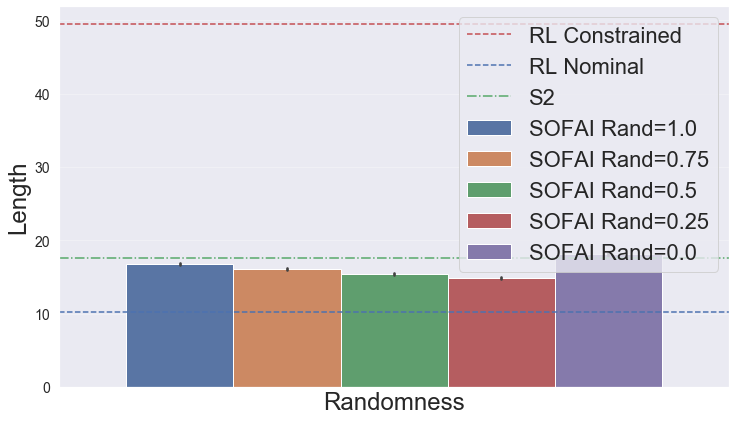

constrained_line: -258.5727928670159 reward
[] <a list of 0 Text xticklabel objects>


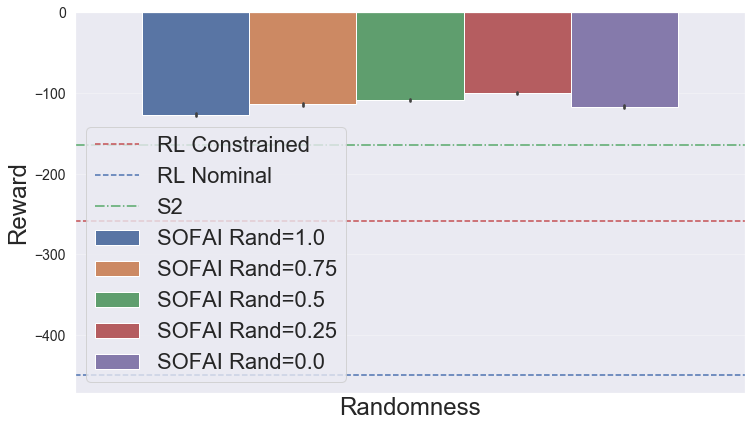

ok
constrained_line: 8.118399999999998 time
[] <a list of 0 Text xticklabel objects>


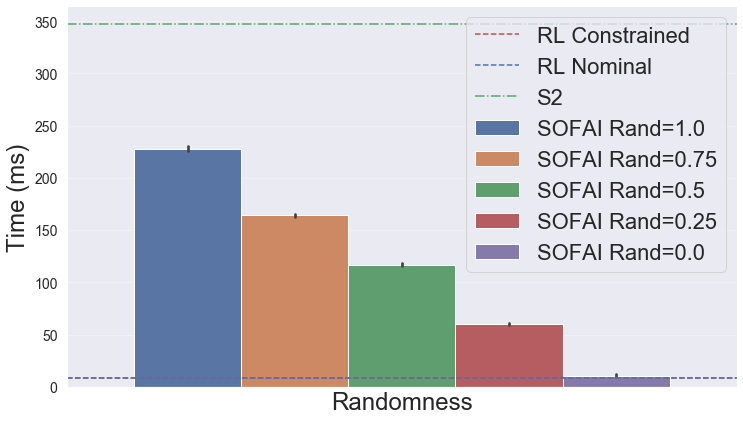

In [59]:
#temp_df = df.loc[(df['traj_n']>=0) & (df['t3']==threshold3) | (df['type']=='S1 noMyopic') | (df['type']=='S2') | (df['type']=='nominal')| (df['type']=='const')]
temp_df = df
#temp_df = temp_df.rename(columns={"01": "SOFAI-01", "s1": "S1-SOFAI"})

label_x = 't3'
label='length'
y_label = 'Length'
min_label, max_label = min_max(label, df)
plot_results(temp_df,x=label_x,y=label, min_label=min_label, max_label=20, y_label= y_label)

label='reward'
y_label = 'Reward'
min_label, max_label = min_max(label, df)
plot_results(temp_df,x=label_x,y=label, min_label=-100, max_label=max_label, y_label= y_label)

label='time'
y_label = 'Time (ms)'
min_label, max_label = min_max(label, df)
print("ok")
plot_results(df,x=label_x,y=label, min_label=min_label, max_label=50, y_label= y_label)

#label='S1_Usage'
#min_label, max_label = min_max(label, df, df2, df3, df4, df7)
#plot_results(df3,x=label_x,y=label, min_label=min_label, max_label=max_label)

In [61]:
def plot_subtype(x, y, df, hue, title, filename, min_label=0, max_label=None, list_threshold3= None, dropna = False, ylabel=""):
    
    print(f"{[min_label, max_label]}")
    sns.set(rc={'figure.figsize':(11.7,8.27)})
    sns.set_theme(style="whitegrid")
    sns.set(font_scale=2)
    sns.color_palette("viridis", as_cmap=True)
    
    plt.rcParams.update({'font.size': 30})
    
    fig = plt.figure(figsize=(50, 15))
    # grid for pairs of subplots
    rows = len(list_threshold3)
    cols = 5
    grid = plt.GridSpec(rows, cols)

    #figure, axis = plt.subplots(len(list_threshold3), 2, figsize=(25, 30))
    #plt.tight_layout()
    #print(axis)

    #for index, t3, sub_plot in enumerate(list_threshold3,axis):
    for i in range(rows):
        plt.xticks(fontsize=30)
        plt.yticks(fontsize=30)
        
        t3 = list_threshold3[i]
        '''# create fake subplot just to title set of subplots
        fake = fig.add_subplot(grid[i, :])
        # '\n' is important
        fake.set_title(f'{title+str(t3)}\n', fontweight='semibold')
        fake.set_axis_off()'''
        
        # create subgrid for two subplots without space between them
        # <https://matplotlib.org/2.0.2/users/gridspec.html>
        #gs = gridspec.GridSpecFromSubplotSpec(1, cols, subplot_spec=grid[i, :])

        # real subplot #1
        ax = plt.subplot(grid[0:1])
        ax.set_title(f'Rand. = 1.0', fontsize=40)
        ax.set_xlabel('Trajectory', fontsize=35)
        ax.set_ylabel(ylabel, fontsize=35)
        #leg = ax.legend(prop={"size":35})
        #ax.xticks(fontsize=35)
        #ax.yticks(fontsize=35)
        #ax.set(xlabel='Trajectory', ylabel = ylabel)
        #ax.set_fontsize(30)
        temp_df = df.loc[(df['traj_n']>=0) & (df['t3']==t3) & ((df['type']=='SOFAI w/ S1 ra=0.0') )  ] #| (df['type']=='s1_nb') 
        if dropna : temp_df = temp_df.dropna()
        g=sns.lineplot(ax=ax, x=x, y=y, data=temp_df, hue_order=['s1','s2'], ci=None, hue=hue,markers=True, dashes=False)
        if max_label: g.set_ylim([min_label, max_label])
        plt.setp(g.get_legend().get_texts(), fontsize='35') # for legend text
        plt.setp(g.get_legend().get_title(), fontsize='35') # for legend title
        g.yaxis.set_tick_params(labelsize = 30)
        g.xaxis.set_tick_params(labelsize = 30)
        #axis[0,0].set_title('Myopic')'''

        # real subplot #2
        ax = plt.subplot(grid[1:2])
        ax.set_title(f'Rand. = 0.75', fontsize=40)
        ax.set_xlabel('Trajectory', fontsize=35)
        ax.set_ylabel(ylabel, fontsize=35)
        temp_df = df.loc[(df['traj_n']>=0) & (df['t3']==t3) &  ((df['type']=='SOFAI w/ S1 ra=0.25') )  ] #| (df['type']=='s1_nb') 
        if dropna : temp_df = temp_df.dropna()
        g=sns.lineplot(ax=ax, x=x, y=y, data=temp_df, hue_order=['s1','s2'], ci=None, hue=hue,markers=True, dashes=False)
        if max_label: g.set_ylim([min_label, max_label])
        plt.setp(g.get_legend().get_texts(), fontsize='35') # for legend text
        plt.setp(g.get_legend().get_title(), fontsize='35') # for legend title
        g.yaxis.set_tick_params(labelsize = 30)
        g.xaxis.set_tick_params(labelsize = 30)
        
        #axis[0,1].set_title('No Myopic')
        
        # real subplot #2
        ax = plt.subplot(grid[2:3])
        ax.set_title(f'Rand. = 0.5', fontsize=40)
        ax.set_xlabel('Trajectory', fontsize=35)
        ax.set_ylabel(ylabel, fontsize=35)
        temp_df = df.loc[(df['traj_n']>=0) & (df['t3']==t3) &  ((df['type']=='SOFAI w/ S1 ra=0.5') )  ] #| (df['type']=='s1_nb') 
        if dropna : temp_df = temp_df.dropna()
        g=sns.lineplot(ax=ax, x=x, y=y, data=temp_df, hue_order=['s1','s2'], ci=None, hue=hue,markers=True, dashes=False)
        if max_label: g.set_ylim([min_label, max_label])
        plt.setp(g.get_legend().get_texts(), fontsize='35') # for legend text
        plt.setp(g.get_legend().get_title(), fontsize='35') # for legend title
        g.yaxis.set_tick_params(labelsize = 30)
        g.xaxis.set_tick_params(labelsize = 30)
            
        # real subplot #2
        ax = plt.subplot(grid[3:4])
        ax.set_title(f'Rand. = 0.25', fontsize=40)
        ax.set_xlabel('Trajectory', fontsize=35)
        ax.set_ylabel(ylabel, fontsize=35)
        temp_df = df.loc[(df['traj_n']>=0) & (df['t3']==t3) &  ((df['type']=='SOFAI w/ S1 ra=0.75') )  ] #| (df['type']=='s1_nb') 
        if dropna : temp_df = temp_df.dropna()
        g=sns.lineplot(ax=ax, x=x, y=y, data=temp_df, hue_order=['s1','s2'], ci=None, hue=hue,markers=True, dashes=False)
        if max_label: g.set_ylim([min_label, max_label])
        plt.setp(g.get_legend().get_texts(), fontsize='35') # for legend text
        plt.setp(g.get_legend().get_title(), fontsize='35') # for legend title
        g.yaxis.set_tick_params(labelsize = 30)
        g.xaxis.set_tick_params(labelsize = 30)
            
        # real subplot #2
        ax = plt.subplot(grid[4:5])
        ax.set_title(f'Rand. = 0.0', fontsize=40)
        ax.set_xlabel('Trajectory', fontsize=35)
        ax.set_ylabel(ylabel, fontsize=35)
        temp_df = df.loc[(df['traj_n']>=0) & (df['t3']==t3) &  ((df['type']=='SOFAI w/ S1 ra=1.0') )  ] #| (df['type']=='s1_nb') 
        if dropna : temp_df = temp_df.dropna()
        g=sns.lineplot(ax=ax, x=x, y=y, data=temp_df, hue_order=['s1','s2'], ci=None, hue=hue,markers=True, dashes=False)
        if max_label: g.set_ylim([min_label, max_label])
        plt.setp(g.get_legend().get_texts(), fontsize='35') # for legend text
        plt.setp(g.get_legend().get_title(), fontsize='35') # for legend title
        g.yaxis.set_tick_params(labelsize = 30)
        g.xaxis.set_tick_params(labelsize = 30)
        
    plt.tight_layout()
    plt.savefig(filename+'.pdf')
    plt.show()



[-15, 1]


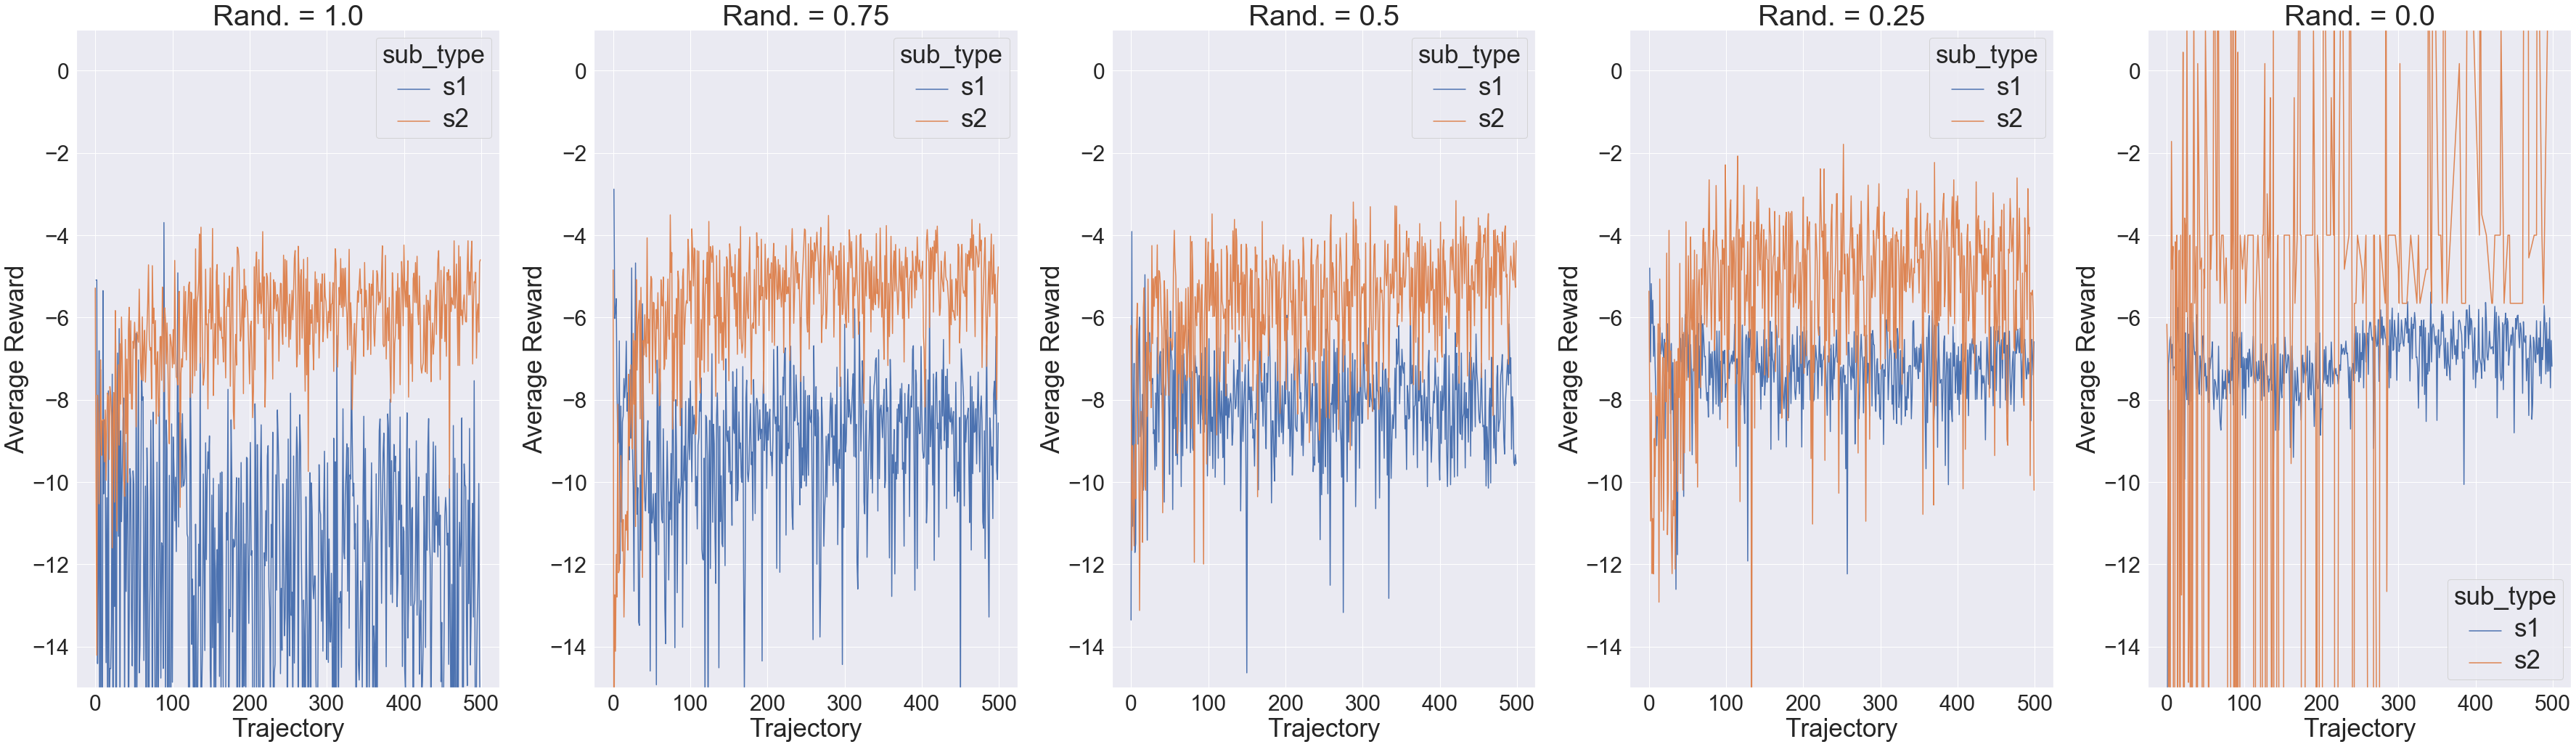

In [74]:
x='traj_n'
y='avg_reward'
ylabel="Average Reward"
#y='avg_time'
filename = y+'_risk_'
title="Avg reward per sub-system, risk avers="

plot_subtype(x,y,df, "sub_type",title,filename, list_threshold3=[0.6,], dropna = True, max_label=1, min_label= -15, ylabel= ylabel)


[0, None]


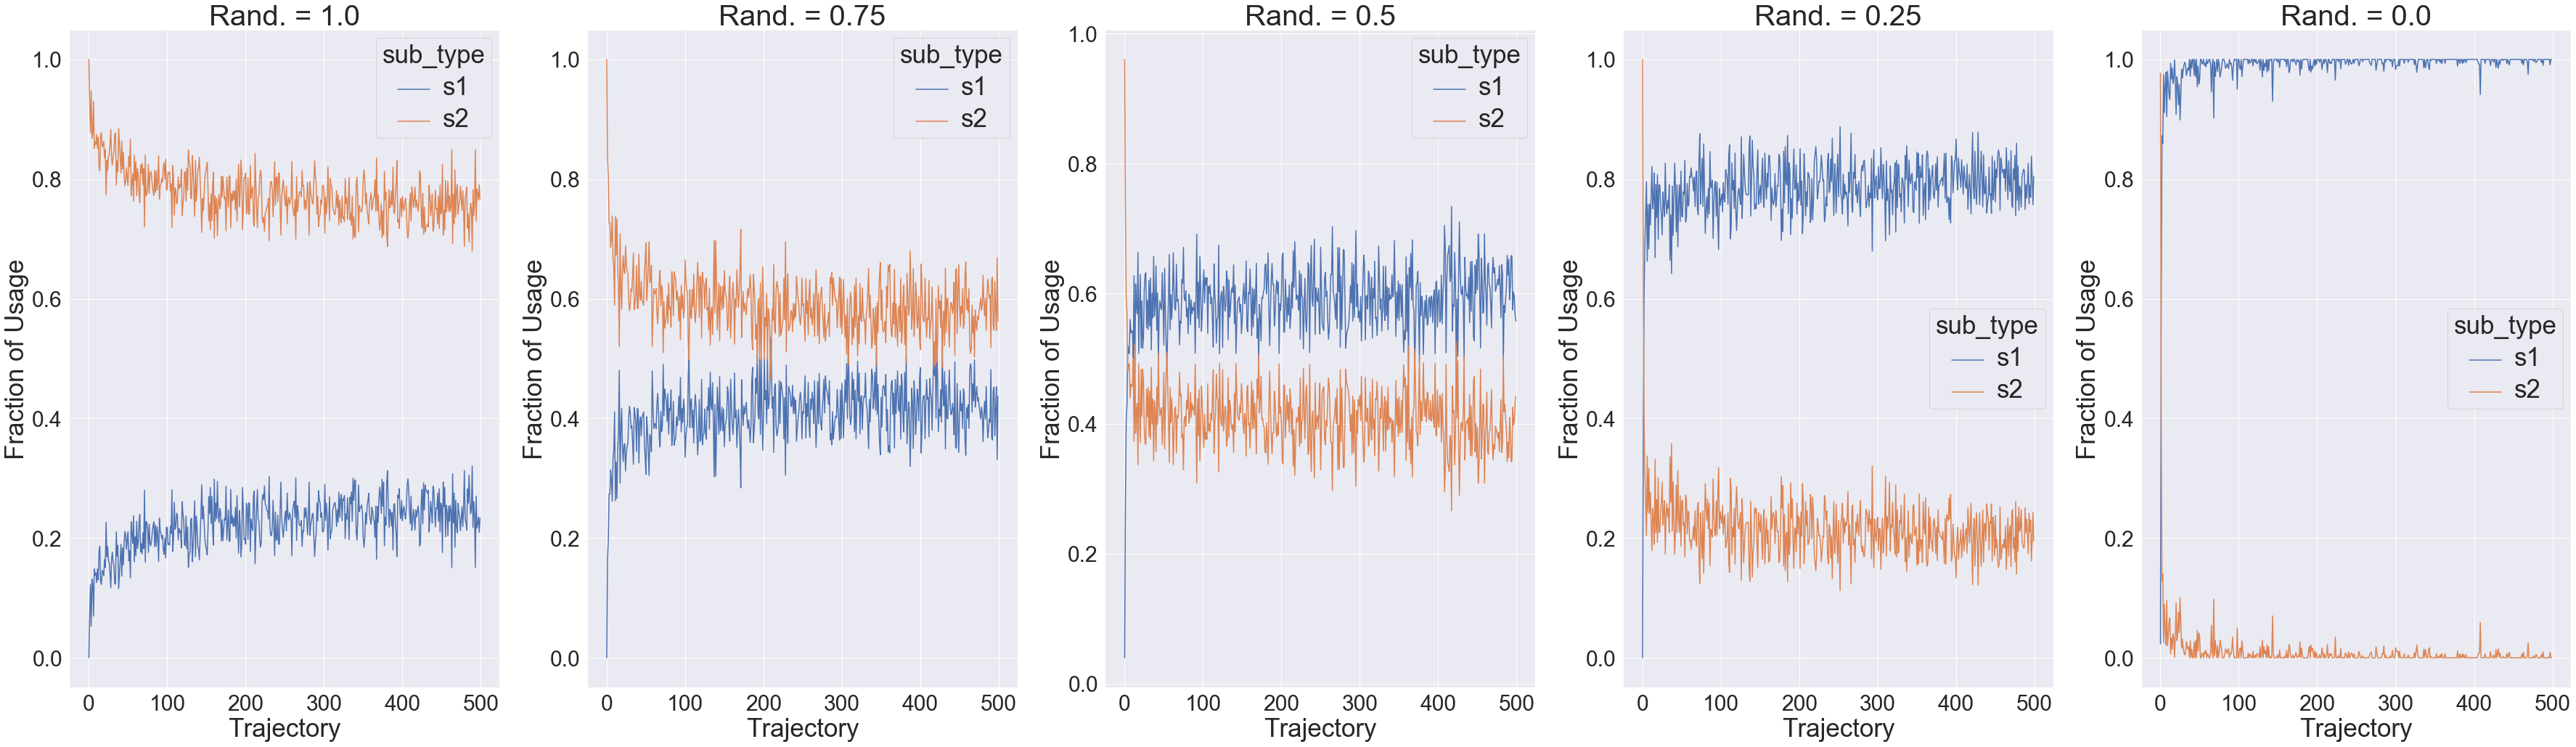

In [75]:
#temp_df = df.loc[(df['traj_n']>=bootstrap) & ( (df['type']=='s1_nb') | (df['type']=='s2')| (df['type']=='01')| (df['type']=='10')| (df['type']=='02'))]


x='traj_n'
y='perc_usage'
ylabel="Fraction of Usage"
#y='avg_time'
filename = y+'_risk_'

plot_subtype(x,y,df, "sub_type",title,filename, list_threshold3=[0.6,], ylabel= ylabel)




[0, 30]


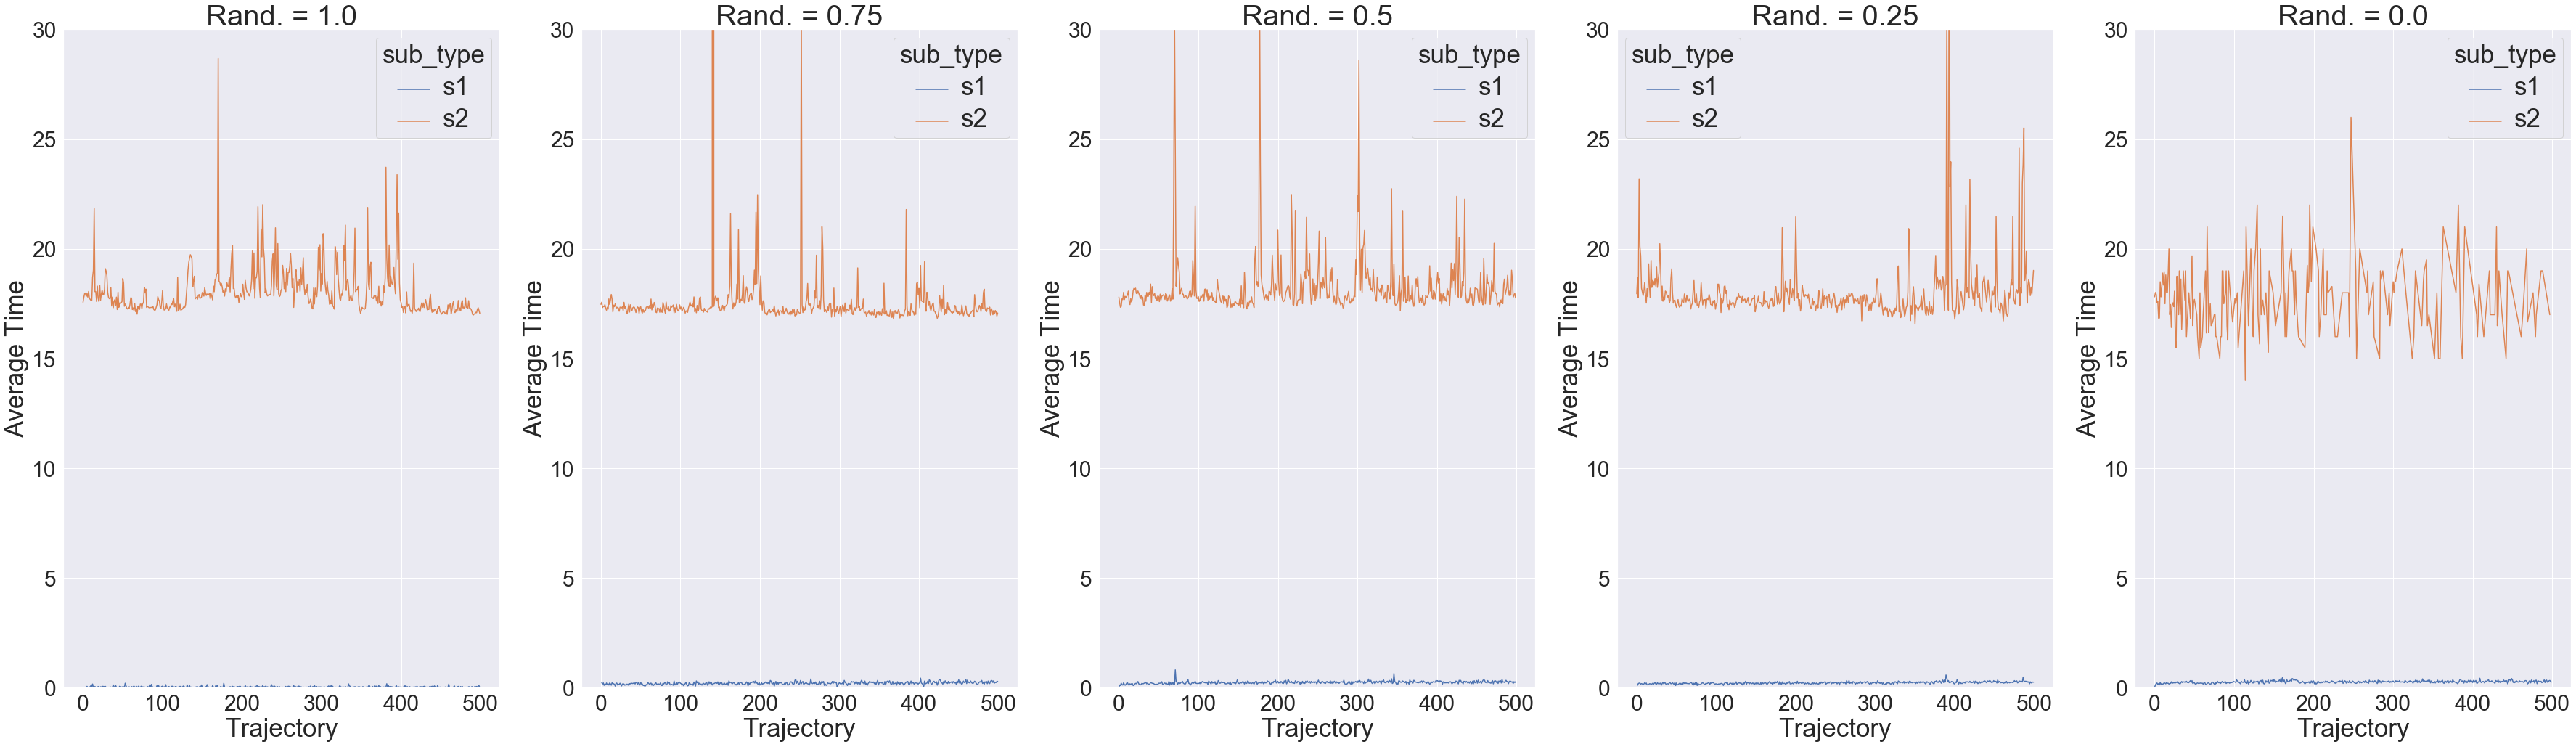

In [78]:
x='traj_n'
y='avg_time'
ylabel="Average Time"
#y='avg_time'
filename = y+'_risk_'

plot_subtype(x,y,df, "sub_type",title,filename, list_threshold3=[0.6,], ylabel= ylabel, dropna = True, max_label=30)


In [46]:
def plot_type(x, y, df, hue, title, filename, min_label=0, max_label=None, list_threshold3= None, dropna=False, ylabel=""):
         
    ci=95
    #print(f"{[min_label, max_label]}")
    sns.set(rc={'figure.figsize':(11.7,8.27)})
    sns.set_theme(style="whitegrid")
    sns.set(font_scale=2)
    sns.color_palette("viridis", as_cmap=True)
    
    fig = plt.figure(figsize=(50, 15))
    # grid for pairs of subplots
    rows = len(list_threshold3)
    cols = 5
    grid = plt.GridSpec(rows, cols)
    #print(df['type'])

    #figure, axis = plt.subplots(len(list_threshold3), 2, figsize=(25, 30))
    #plt.tight_layout()
    #print(axis)

    #for index, t3, sub_plot in enumerate(list_threshold3,axis):
    for i in range(rows):
        
        t3 = list_threshold3[i]

        
        ax = plt.subplot(grid[0:1])
        ax.set_title(f'Rand. = 1.0', fontsize=40)
        ax.set_xlabel('Trajectory', fontsize=35)
        ax.set_ylabel(ylabel, fontsize=35)
        #leg = ax.legend(prop={"size":35})
        #ax.xticks(fontsize=35)
        #ax.yticks(fontsize=35)
        #ax.set(xlabel='Trajectory', ylabel = ylabel)
        #ax.set_fontsize(30)
        temp_df = df.loc[(df['traj_n']>=0) & (df['t3']==t3) & ((df['type']=='SOFAI w/ S1 ra=0.0') ) | (df['t3']==0) ] #| (df['type']=='s1_nb') 
        if dropna : temp_df = temp_df.dropna()
        #g=sns.lineplot(ax=ax, x=x, y=y, data=temp_df, hue_order=['s1','s2'], ci=None, hue=hue,markers=True, dashes=False)
        g=sns.lineplot(ax=ax, x=x, y=y, data=temp_df, hue_order=['S2', 'SOFAI w/ S1 ra=0.0'], ci=ci, hue=hue,markers=True, dashes=False)
        plt.legend(labels=['S2', 'SOFAI'])
        if max_label: g.set_ylim([min_label, max_label])
        plt.setp(g.get_legend().get_texts(), fontsize='35') # for legend text
        plt.setp(g.get_legend().get_title(), fontsize='35') # for legend title
        g.yaxis.set_tick_params(labelsize = 30)
        g.xaxis.set_tick_params(labelsize = 30)
        #axis[0,0].set_title('Myopic')'''

        ax = plt.subplot(grid[1:2])
        ax.set_title(f'Rand. = 0.75', fontsize=40)
        ax.set_xlabel('Trajectory', fontsize=35)
        ax.set_ylabel(ylabel, fontsize=35)
        #leg = ax.legend(prop={"size":35})
        #ax.xticks(fontsize=35)
        #ax.yticks(fontsize=35)
        #ax.set(xlabel='Trajectory', ylabel = ylabel)
        #ax.set_fontsize(30)
        temp_df = df.loc[(df['traj_n']>=0) & (df['t3']==t3) & ((df['type']=='SOFAI w/ S1 ra=0.25') ) | (df['t3']==0) ] #| (df['type']=='s1_nb') 
        if dropna : temp_df = temp_df.dropna()
        #g=sns.lineplot(ax=ax, x=x, y=y, data=temp_df, hue_order=['s1','s2'], ci=None, hue=hue,markers=True, dashes=False)
        g=sns.lineplot(ax=ax, x=x, y=y, data=temp_df, hue_order=['S2', 'SOFAI w/ S1 ra=0.25'], ci=ci, hue=hue,markers=True, dashes=False)
        plt.legend(labels=['S2', 'SOFAI'])
        if max_label: g.set_ylim([min_label, max_label])
        plt.setp(g.get_legend().get_texts(), fontsize='35') # for legend text
        plt.setp(g.get_legend().get_title(), fontsize='35') # for legend title
        g.yaxis.set_tick_params(labelsize = 30)
        g.xaxis.set_tick_params(labelsize = 30)
        #axis[0,0].set_title('Myopic')'''
            
        ax = plt.subplot(grid[2:3])
        ax.set_title(f'Rand. = 0.5', fontsize=40)
        ax.set_xlabel('Trajectory', fontsize=35)
        ax.set_ylabel(ylabel, fontsize=35)
        #leg = ax.legend(prop={"size":35})
        #ax.xticks(fontsize=35)
        #ax.yticks(fontsize=35)
        #ax.set(xlabel='Trajectory', ylabel = ylabel)
        #ax.set_fontsize(30)
        temp_df = df.loc[(df['traj_n']>=0) & (df['t3']==t3) & ((df['type']=='SOFAI w/ S1 ra=0.5') ) | (df['t3']==0) ] #| (df['type']=='s1_nb') 
        if dropna : temp_df = temp_df.dropna()
        #g=sns.lineplot(ax=ax, x=x, y=y, data=temp_df, hue_order=['s1','s2'], ci=None, hue=hue,markers=True, dashes=False)
        g=sns.lineplot(ax=ax, x=x, y=y, data=temp_df, hue_order=['S2', 'SOFAI w/ S1 ra=0.5'], ci=ci, hue=hue,markers=True, dashes=False)
        plt.legend(labels=['S2', 'SOFAI'])
        if max_label: g.set_ylim([min_label, max_label])
        plt.setp(g.get_legend().get_texts(), fontsize='35') # for legend text
        plt.setp(g.get_legend().get_title(), fontsize='35') # for legend title
        g.yaxis.set_tick_params(labelsize = 30)
        g.xaxis.set_tick_params(labelsize = 30)
        #axis[0,0].set_title('Myopic')'''
            
        ax = plt.subplot(grid[3:4])
        ax.set_title(f'Rand. = 0.25', fontsize=40)
        ax.set_xlabel('Trajectory', fontsize=35)
        ax.set_ylabel(ylabel, fontsize=35)
        #leg = ax.legend(prop={"size":35})
        #ax.xticks(fontsize=35)
        #ax.yticks(fontsize=35)
        #ax.set(xlabel='Trajectory', ylabel = ylabel)
        #ax.set_fontsize(30)
        temp_df = df.loc[(df['traj_n']>=0) & (df['t3']==t3) & ((df['type']=='SOFAI w/ S1 ra=0.75') ) | (df['t3']==0) ] #| (df['type']=='s1_nb') 
        if dropna : temp_df = temp_df.dropna()
        #g=sns.lineplot(ax=ax, x=x, y=y, data=temp_df, hue_order=['s1','s2'], ci=None, hue=hue,markers=True, dashes=False)
        g=sns.lineplot(ax=ax, x=x, y=y, data=temp_df, hue_order=['S2', 'SOFAI w/ S1 ra=0.75'], ci=ci, hue=hue,markers=True, dashes=False)
        plt.legend(labels=['S2', 'SOFAI'])
        if max_label: g.set_ylim([min_label, max_label])
        plt.setp(g.get_legend().get_texts(), fontsize='35') # for legend text
        plt.setp(g.get_legend().get_title(), fontsize='35') # for legend title
        g.yaxis.set_tick_params(labelsize = 30)
        g.xaxis.set_tick_params(labelsize = 30)
        #axis[0,0].set_title('Myopic')'''
            
        ax = plt.subplot(grid[4:5])
        ax.set_title(f'Rand. = 0.0', fontsize=40)
        ax.set_xlabel('Trajectory', fontsize=35)
        ax.set_ylabel(ylabel, fontsize=35)
        #leg = ax.legend(prop={"size":35})
        #ax.xticks(fontsize=35)
        #ax.yticks(fontsize=35)
        #ax.set(xlabel='Trajectory', ylabel = ylabel)
        #ax.set_fontsize(30)
        temp_df = df.loc[(df['traj_n']>=0) & (df['t3']==t3) & ((df['type']=='SOFAI w/ S1 ra=1.0') ) | (df['t3']==0) ] #| (df['type']=='s1_nb') 
        if dropna : temp_df = temp_df.dropna()
        #g=sns.lineplot(ax=ax, x=x, y=y, data=temp_df, hue_order=['s1','s2'], ci=None, hue=hue,markers=True, dashes=False)
        g=sns.lineplot(ax=ax, x=x, y=y, data=temp_df, hue_order=['S2', 'SOFAI w/ S1 ra=1.0'], ci=ci, hue=hue,markers=True, dashes=False)
        plt.legend(labels=['S2', 'SOFAI'])
        if max_label: g.set_ylim([min_label, max_label])
        plt.setp(g.get_legend().get_texts(), fontsize='35') # for legend text
        plt.setp(g.get_legend().get_title(), fontsize='35') # for legend title
        g.yaxis.set_tick_params(labelsize = 30)
        g.xaxis.set_tick_params(labelsize = 30)
        #axis[0,0].set_title('Myopic')'''

    plt.tight_layout()
    plt.savefig(filename+'.pdf')
    plt.show()


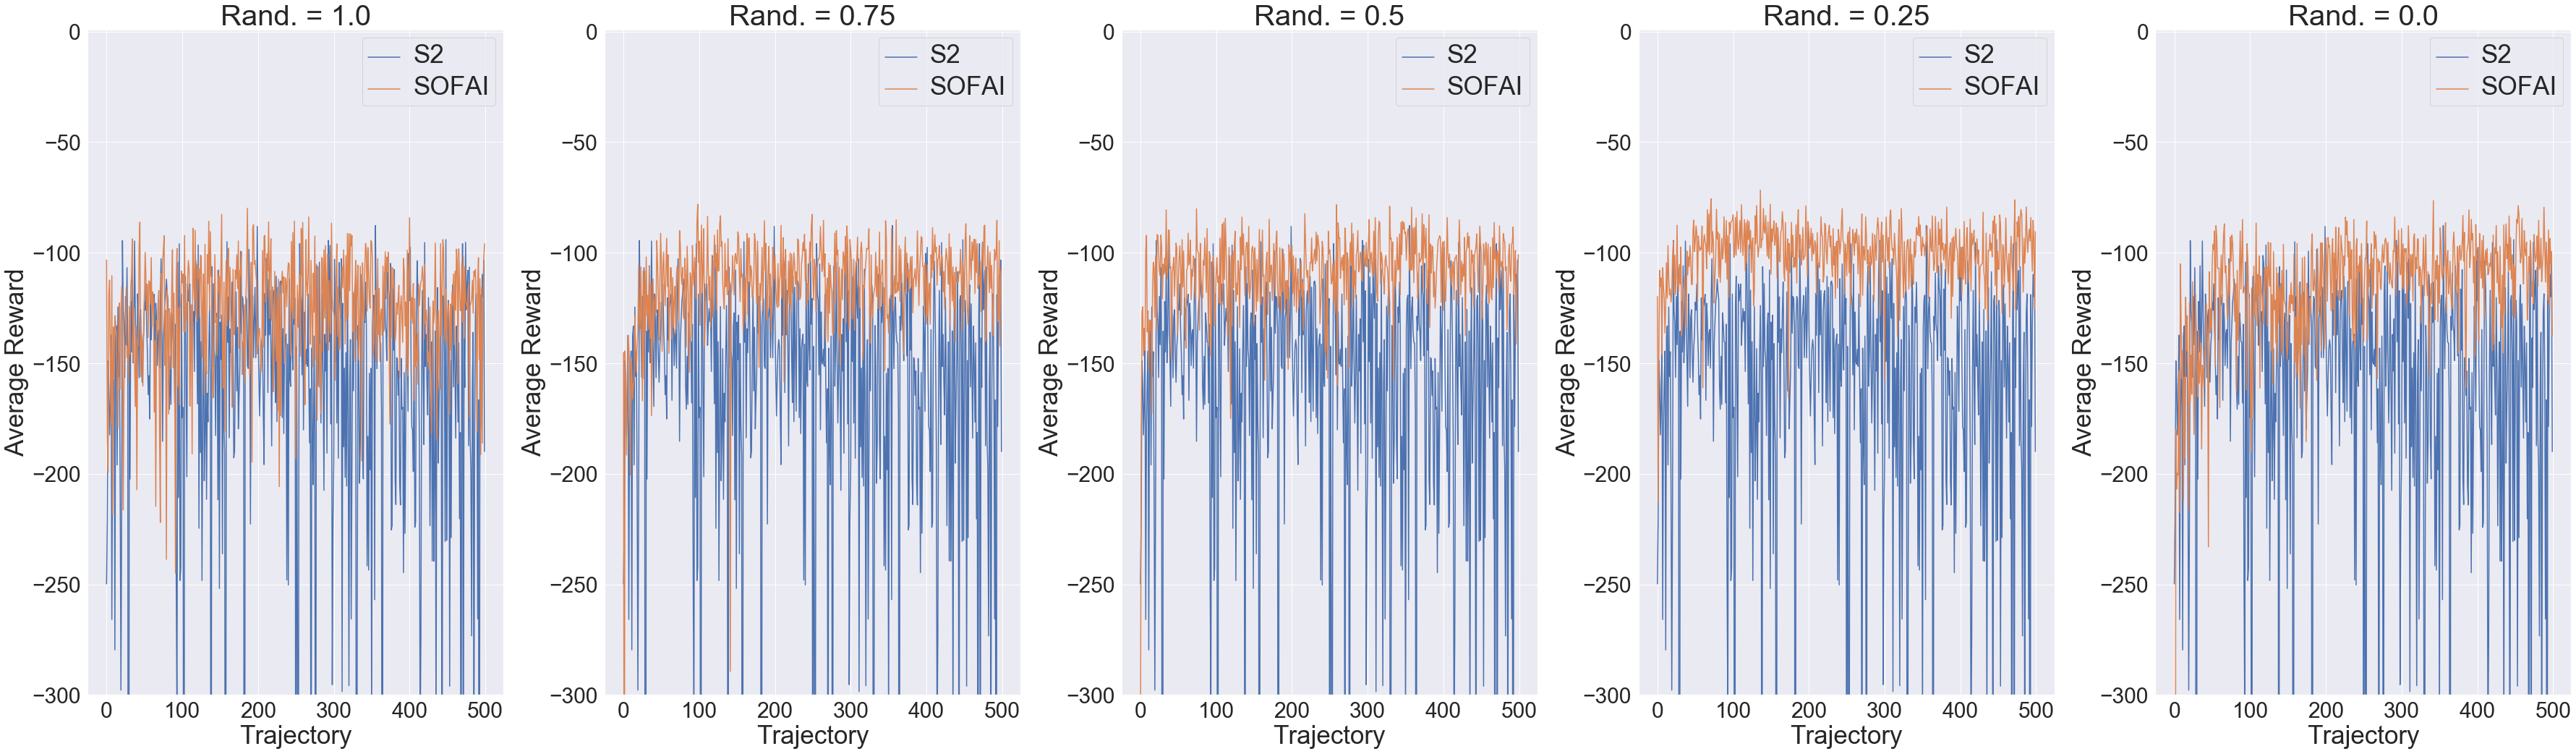

'y=\'time\'\n\nfilename = \'avg_time_per_traj\'\ntitle="Avg time per traj, risk avers="\n\nplot_type(x,y,temp_df,"type",title,filename, list_threshold3=list_threshold3, max_label=300)'

In [40]:
#temp_df = df.loc[(df['traj_n']>=bootstrap) & ( (df['type']=='s1_nb') | (df['type']=='s2')| (df['type']=='01')| (df['type']=='10')| (df['type']=='02'))]
#temp_df = df.loc[(df['traj_n']>=bootstrap) & ( (df['type']=='S2')|  (df['type']=='SOFAI w/ no Myopic S1') |  (df['type']=='SOFAI w/ Myopic S1'))]
#temp_df = df.loc[(df['traj_n']>=0) & ((df['type']=='01') )  ] #| (df['type']=='s1_nb') 

#print(temp_df)

x='traj_n'
#y='perc_usage'
y='reward'
#y='time'


filename = 'avg_reward_per_traj'
title="Avg reward per traj, risk avers="

plot_type(x,y,df,"type",title,filename, list_threshold3=[0.6,], max_label=1, min_label=-300, ylabel="Average Reward")
#plot_subtype(x,y,temp_df, "type",title,filename, list_threshold3=list_threshold3)


'''y='time'

filename = 'avg_time_per_traj'
title="Avg time per traj, risk avers="

plot_type(x,y,temp_df,"type",title,filename, list_threshold3=list_threshold3, max_label=300)'''



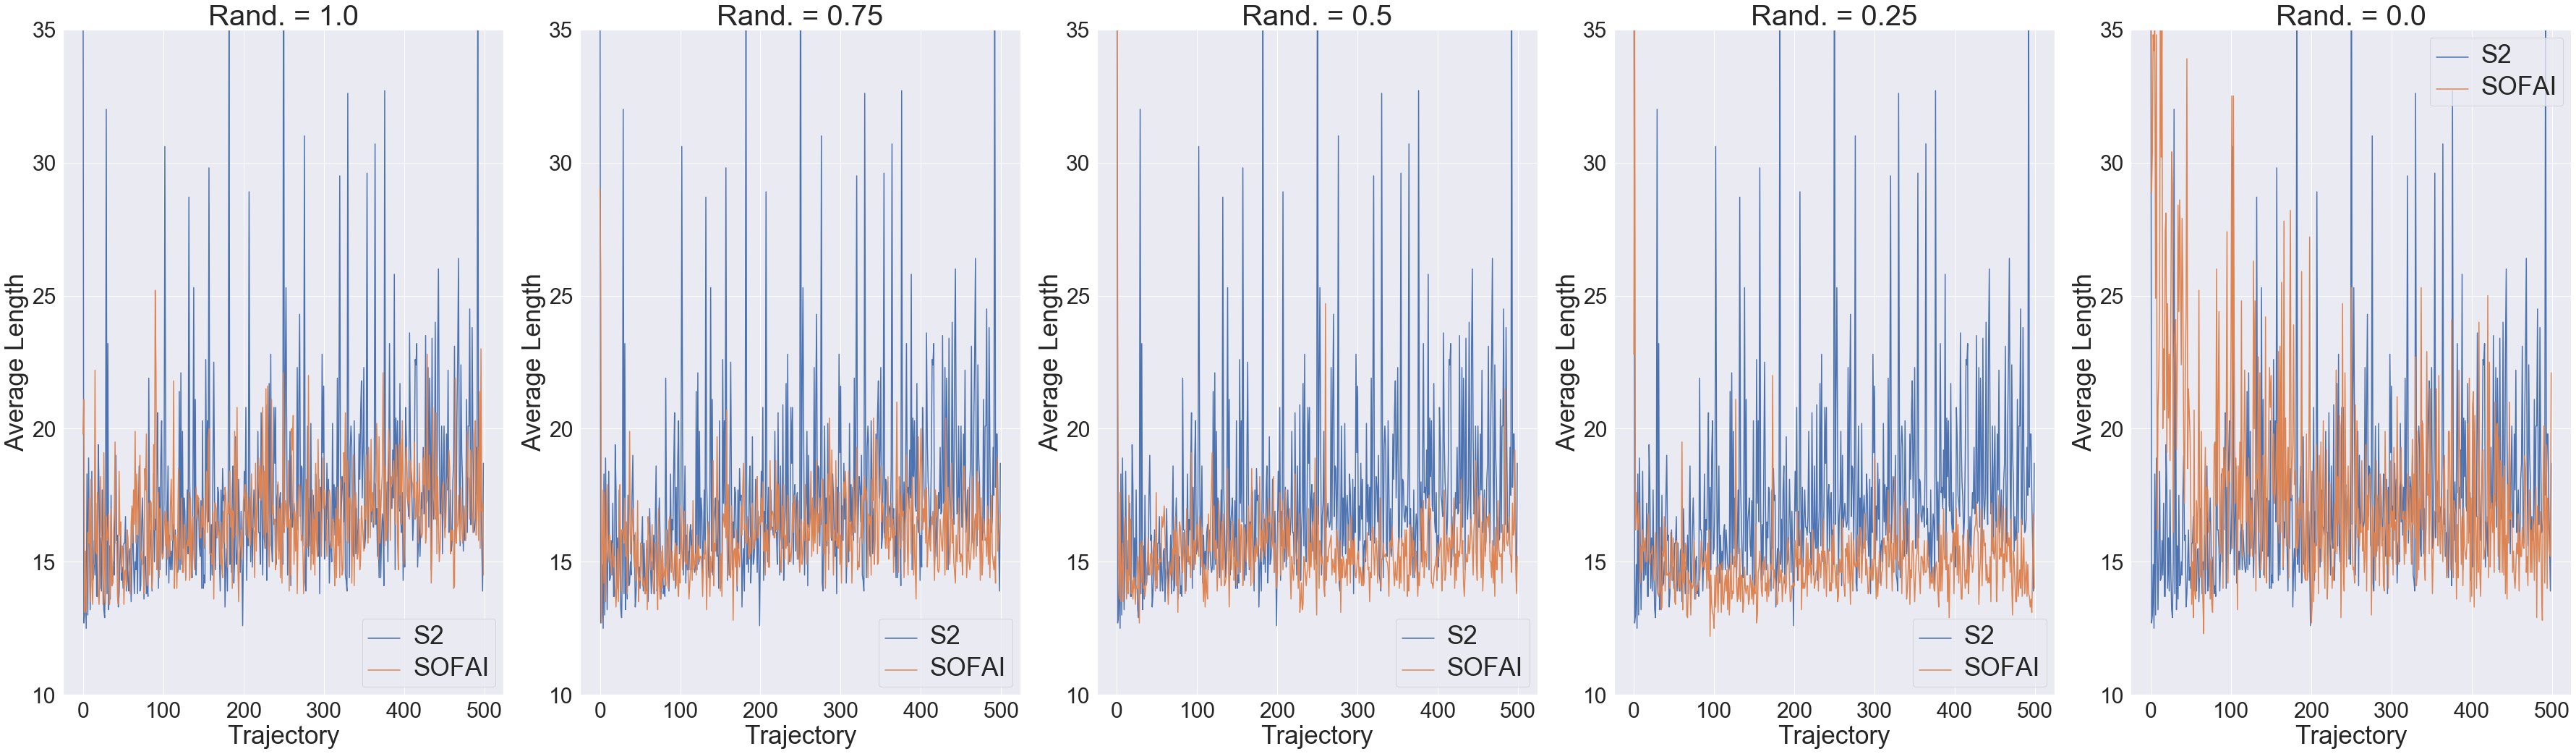

In [43]:
#temp_df = df.loc[(df['traj_n']>=bootstrap) & ( (df['type']=='S2')|  (df['type']=='SOFAI w/ no Myopic S1') |  (df['type']=='SOFAI w/ Myopic S1'))]
#temp_df = df.loc[(df['traj_n']>=bootstrap) & ( (df['type']=='S2')|  (df['type']=='SOFAI w/ no Myopic S1') |  (df['type']=='SOFAI w/ Myopic S1'))]

y='length'

filename = 'avg_length_per_traj'
title="Avg length per traj, risk avers="

plot_type(x,y,df,"type",title,filename, list_threshold3=[0.6,], ylabel="Average Length", min_label=10, max_label=35)

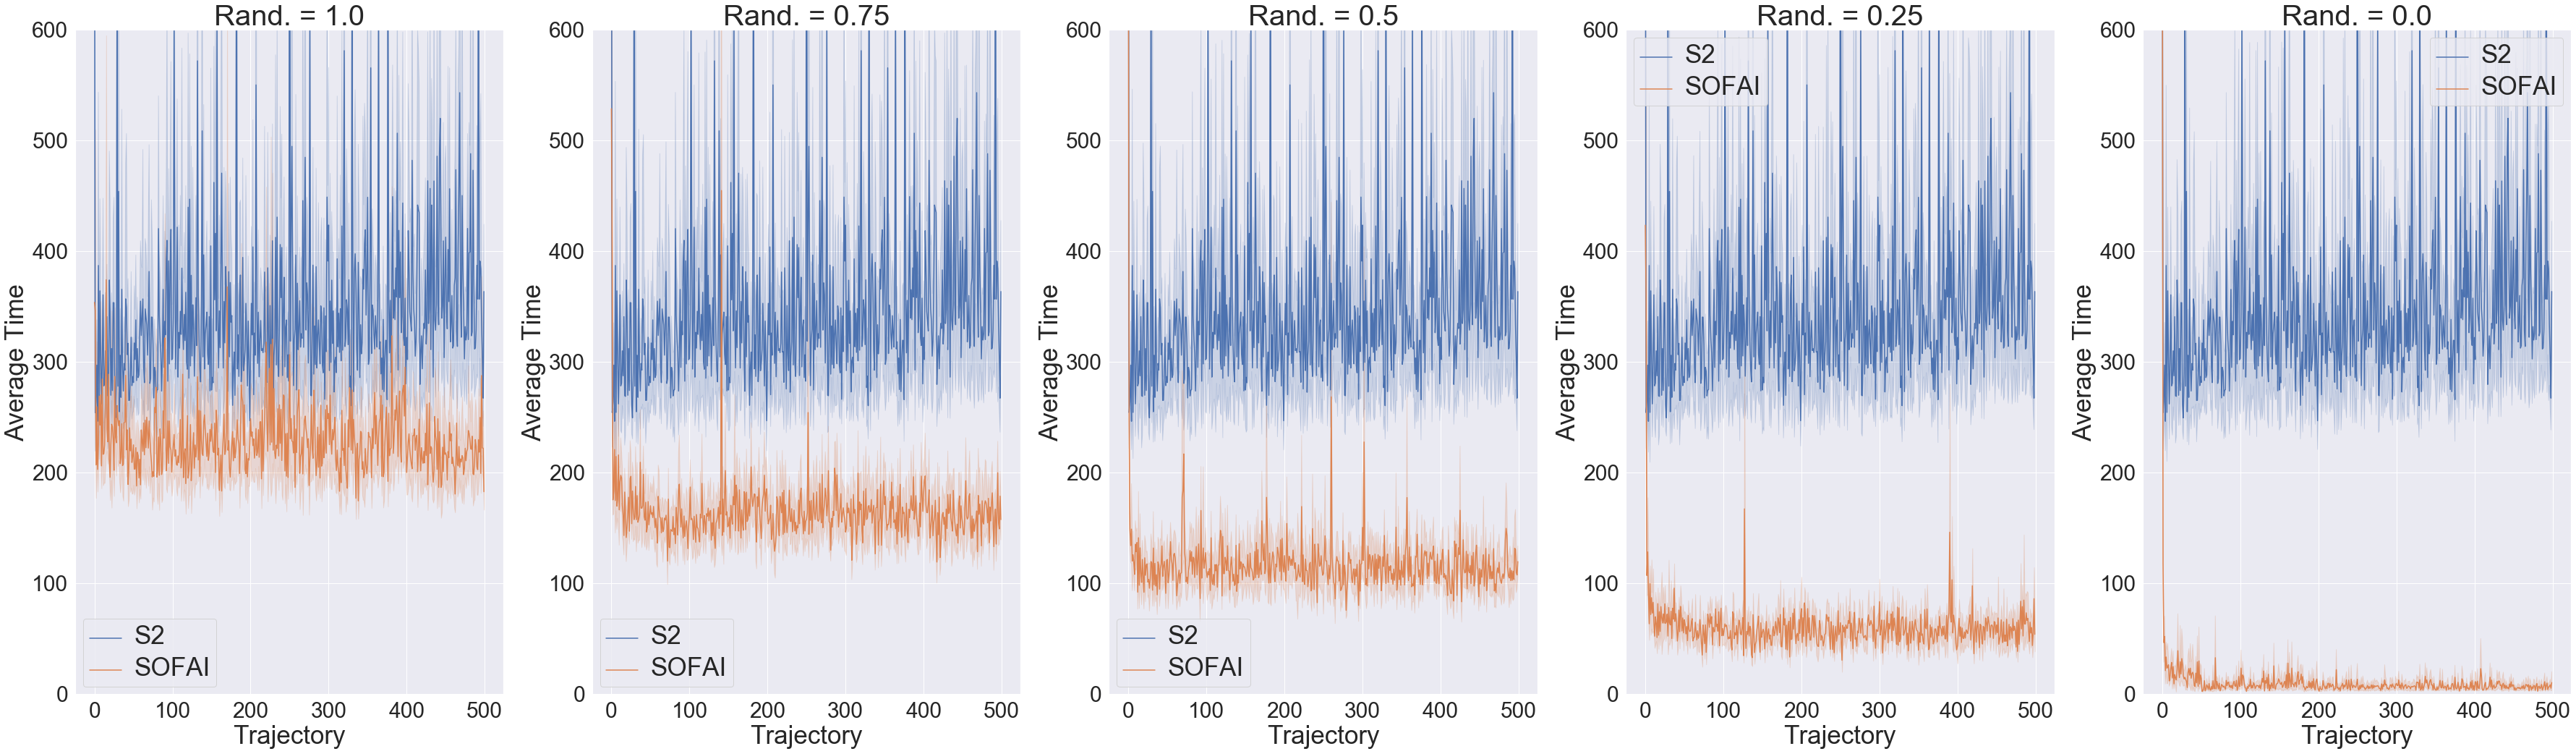

In [47]:
#temp_df = df.loc[(df['traj_n']>=bootstrap) & ( (df['type']=='s1_nb') | (df['type']=='s2')| (df['type']=='01')| (df['type']=='10')| (df['type']=='02'))]
#temp_df = df.loc[(df['traj_n']>=bootstrap) & ( (df['type']=='S2')| (df['type']=='S1 Myopic')|  (df['type']=='SOFAI w/ no Myopic S1') |  (df['type']=='SOFAI w/ Myopic S1'))]

y='time'
filename = 'avg_time_withS1_per_traj'
title="Avg time per traj, risk avers="

plot_type(x,y,df,"type",title,filename, list_threshold3=[0.6,], ylabel="Average Time", min_label=-1, max_label=600)


In [43]:
'''#temp_df = df.loc[(df['traj_n']>=bootstrap) & ( (df['type']=='S2')| (df['type']=='S1 Myopic')| (df['type']=='SOFAI w/ no Myopic S1') |  (df['type']=='SOFAI w/ Myopic S1'))]

y='length'
filename = 'avg_length_withS1_per_traj'
title="Avg length per traj, risk avers="

plot_type(x,y,df,"type",title,filename, list_threshold3=list_threshold3)'''

'#temp_df = df.loc[(df[\'traj_n\']>=bootstrap) & ( (df[\'type\']==\'S2\')| (df[\'type\']==\'S1 Myopic\')| (df[\'type\']==\'SOFAI w/ no Myopic S1\') |  (df[\'type\']==\'SOFAI w/ Myopic S1\'))]\n\ny=\'length\'\nfilename = \'avg_length_withS1_per_traj\'\ntitle="Avg length per traj, risk avers="\n\nplot_type(x,y,df,"type",title,filename, list_threshold3=list_threshold3)'

[0, 3]


/Users/aloreggia/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Users/aloreggia/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Users/aloreggia/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:74: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently re

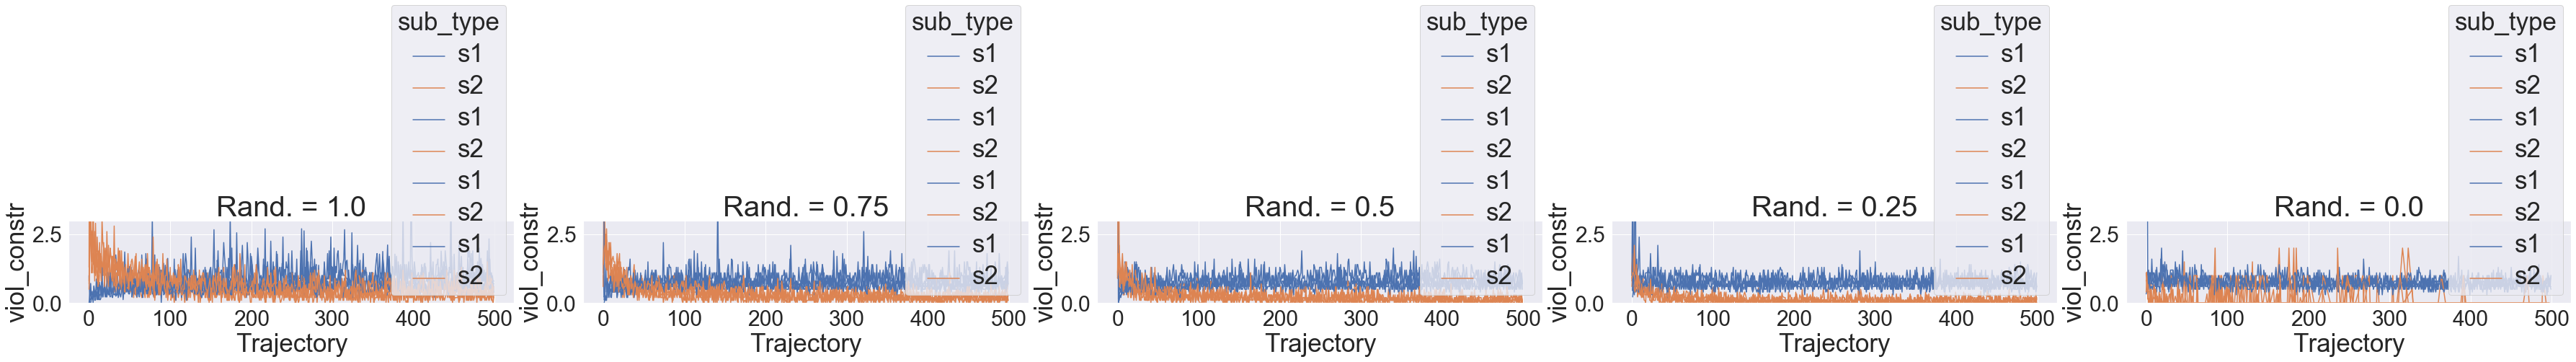

In [63]:
#temp_df = df.loc[(df['traj_n']>=bootstrap) & ( (df['type']=='S2')|  (df['type']=='SOFAI w/ no Myopic S1'))]

y='viol_constr'
filename = 'avg_viol_per_traj'
title="Avg viol per traj, risk avers="

plot_subtype(x,y,df,"sub_type",title,filename, list_threshold3=list_threshold3, dropna=True, max_label=3)

/Users/aloreggia/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Users/aloreggia/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Users/aloreggia/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:69: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently re

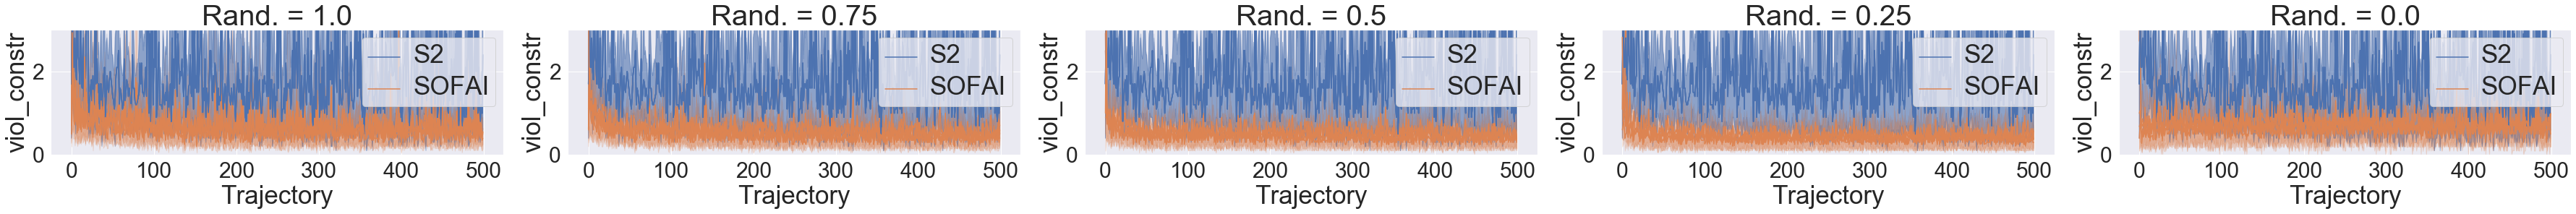

In [64]:
#temp_df = df.loc[(df['traj_n']>=bootstrap) & ( (df['type']=='S2')|  (df['type']=='SOFAI w/ no Myopic S1'))]

y='viol_constr'
filename = 'avg_viol_aggregated_per_traj'
title="Avg viol per traj, risk avers="

plot_type(x,y,df,"type",title,filename, list_threshold3=list_threshold3, dropna=True, max_label=3)

In [46]:
#js_div = pd.read_csv('remaining_time/same_grid/risk0.8/jsdiv_myopic_nomyopic_risk_0.8.csv')
#temp_df = js_div.loc[((js_div['t3']==threshold3) & (js_div['t4']==threshold4)) | (js_div['type']=='s1_nb')]
temp_df =js_div

y='jsdiv'


fig=plt.figure(figsize=(12, 7))
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.set_theme(style="whitegrid")
sns.set(font_scale=2)
sns.color_palette("viridis", as_cmap=True)
g = sns.barplot(x='t3', y=y, hue="type", data=temp_df, palette="autumn", ci=95);

h, l = g.get_legend_handles_labels()
#labels=['S1',"SOFAI 01","SOFAI 10","SOFAI 02"]
#g.legend(h, labels)


plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.xlabel("t3")
plt.ylabel("JS div")
plt.title("JS Divergence")
plt.show()
fig.savefig(f"avg_js_dist.pdf", bbox_inches = 'tight') 

NameError: name 'js_div' is not defined

In [ ]:
#mca_01_myopic.__dict__

In [ ]:
#temp_dict


In [ ]:
temp_matrix = count_states(demo_n.trajectories, n_cfg.mdp, n, constraints)

Z_distr = f(temp_matrix)
#print(int(start%9))
Z_distr[8-int(start/9)][int(start%9)]=0
Z_distr[8-int(goal/9)][int(goal%9)]

Z_distr = np.array(Z_distr)
Z_distr = Z_distr + 1E-3

plt.imshow(Z_distr/np.sum(Z_distr), cmap='hot', interpolation='nearest')
plt.show()

Z_distr/np.sum(Z_distr)
distr = np.array(Z_distr/np.sum(Z_distr))


np.random.choice(np.arange(0,81), replace=False, p = distr.flatten())

In [ ]:
mca_01_noMyopic.thresholds_stat

In [ ]:
m = [np.sum(mca_01_noMyopic.modelSelf.s1_wrong_list[-200-i:-i]) / len(mca_01_noMyopic.modelSelf.s1_wrong_list[-200-i:-i]) for i in range(1,len(mca_01_noMyopic.modelSelf.s1_wrong_list))]

In [ ]:
m.reverse()

In [ ]:
plt.plot(m)
plt.show()

In [ ]:
#m = [np.sum(mca_01_myopic.modelSelf.s1_wrong_list[-200-i:-i]) / len(mca_01_myopic.modelSelf.s1_wrong_list[-200-i:-i]) for i in range(1,len(mca_01_myopic.modelSelf.s1_wrong_list))]

In [ ]:
#mca_01_noMyopic.action_reward

In [ ]:
m2 = [np.sum(mca_01_noMyopic.modelSelf.s2_wrong_list[-200-i:-i]) / len(mca_01_noMyopic.modelSelf.s2_wrong_list[-200-i:-i]) for i in range(1,len(mca_01_noMyopic.modelSelf.s2_wrong_list))]
m2.reverse()
plt.plot(m2)
plt.show()

In [ ]:
sum(mca_01_noMyopic.modelSelf.__dict__['s2_wrong_list'][0:200])/200

In [ ]:
[np.sum(mca_01_noMyopic.modelSelf.s1_wrong_list[-200-i:-i]) / len(mca_01_noMyopic.modelSelf.s1_wrong_list[-200-i:-i]) for i in range(1,len(mca_01_noMyopic.modelSelf.s1_wrong_list))]

In [ ]:
mca_01_noMyopic.modelSelf.s1_wrong_list[-200:-1]

In [ ]:
max_time = max(df.time)
temp_df = df
temp_df['rew_time'] = df.apply(lambda row: (-1)/(row.reward)*(row.time/max_time) , axis = 1)

In [ ]:
temp_df_small = temp_df.loc[(temp_df['traj_n']>=bootstrap) & (temp_df['type']=='SOFAI w/ no Myopic S1') ]

x='time'
y='rew_time'

filename = 'avg_rewtime_per_traj'
title="Avg rew/time per traj, risk avers="

#plot_type(x,y,temp_df_small,"sub_type",title,filename, list_threshold3=list_threshold3, min_label=-200, max_label=1)

sns.scatterplot(data=temp_df_small, x=x, y=y, hue="sub_type")
plt.show()

In [ ]:
temp_df.iloc[1]

In [ ]:
max(df.time)

In [ ]:
mca_01_myopic.modelSelf.__dict__.keys()

In [ ]:
df[['type','sub_type','viol_constr','Viol']]

In [ ]:
!pwd

In [ ]:
#df=pd.read_csv('/Users/aloreggia/Documents/GitHub/wmca/notebooks/lastRound/endInterval/datiReload.csv')
df=pd.read_csv('/Users/aloreggia/Documents/GitHub/wmca/notebooks/lastRound/midInterval/datiReload.csv')

In [ ]:
df